***Note: Google Colab has been used to run the the file***

# WHY FAKE NEWS IS A PROBLEM?
**Fake news refers to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours.Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media.**
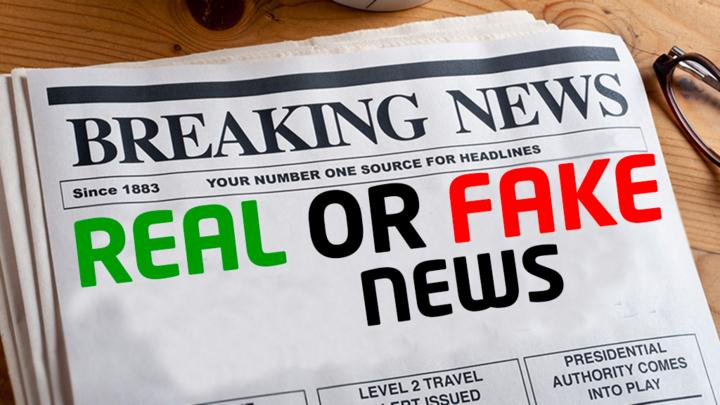

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# pip install keras-preprocessing


## STEP 1: Import necessary libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

## STEP 2: Load the dataset
- The dataset is stored in the Google Drive folder (news) with two files (True.csv & Fake.csv).

#### **BRIEF DESCRIPTION OF DATASET**
This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.


In [5]:
true = pd.read_csv("../12_Advanced NLP Techniques/news/True.csv")
false = pd.read_csv("../12_Advanced NLP Techniques/news/Fake.csv")

In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [9]:
false['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

## STEP 3: Combine the datasets

In [10]:
true['category'] = 1
false['category'] = 0
df = pd.concat([true, false])

In [11]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

## STEP 4: Clean the data

In [12]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    cleaned_text = " ".join(final_text)

    # Check if the cleaned text is empty
    if not cleaned_text:
        cleaned_text = "placeholder"  # Add a placeholder word

    return cleaned_text

df['clean_text'] = df['text'].apply(clean_text)

## STEP 5: Word cloud for real and fake text


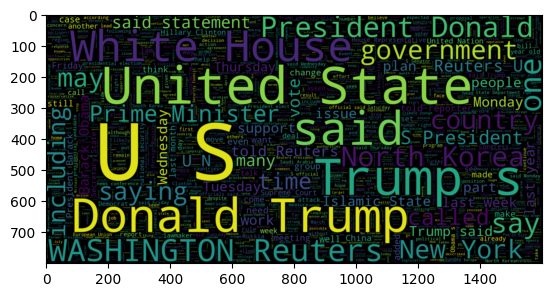

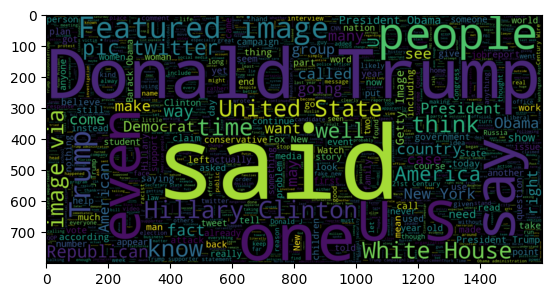

In [13]:
# Word cloud for real and fake text
def plot_wordcloud(category):
    wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == category].clean_text))
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

# Plot word cloud for real text
plot_wordcloud(1)

# Plot word cloud for fake text
plot_wordcloud(0)


## STEP 6: Split the data into training and testing sets

In [14]:

x_train, x_test, y_train, y_test = train_test_split(df.clean_text, df.category, random_state=0)

## STEP 7: Tokenizing text and padding sequences

In [15]:
max_features = 10000
maxlen = 300
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [16]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

# Step 11: Load pre-trained GloVe embeddings
EMBEDDING_FILE = '../12_Advanced NLP Techniques/news/glove.twitter.27B.100d.txt'

def load_embeddings(embedding_file, word_index, max_features):
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding='utf-8'))
    
    # Filter to ensure all values are numpy arrays
    embeddings_values = [v for v in embeddings_index.values() if isinstance(v, np.ndarray)]
    
    # Check if we have valid embeddings
    if not embeddings_values:
        raise ValueError("No valid embeddings found.")

    all_embs = np.stack(embeddings_values)
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, embed_size

embedding_matrix, embed_size = load_embeddings(EMBEDDING_FILE, tokenizer.word_index, max_features)

## STEP 8: Model definition and training

In [17]:
batch_size = 256
epochs = 3
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8279 - loss: 0.3926 - val_accuracy: 0.9491 - val_loss: 0.1416 - learning_rate: 0.0010
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.9426 - loss: 0.1549 - val_accuracy: 0.9773 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 3592s 27s/step - accuracy: 0.9569 - loss: 0.1181 - val_accuracy: 0.9847 - val_loss: 0.0472 - learning_rate: 0.0010


## STEP 9: Model evaluation and analysis

In [18]:
print("Accuracy on Training Data:", model.evaluate(x_train, y_train)[1] * 100, "%")
print("Accuracy on Testing Data:", model.evaluate(x_test, y_test)[1] * 100, "%")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 125s 118ms/step - accuracy: 0.9852 - loss: 0.0427
Accuracy on Training Data: 98.51810336112976 %
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.9848 - loss: 0.0475
Accuracy on Testing Data: 98.46770763397217 %


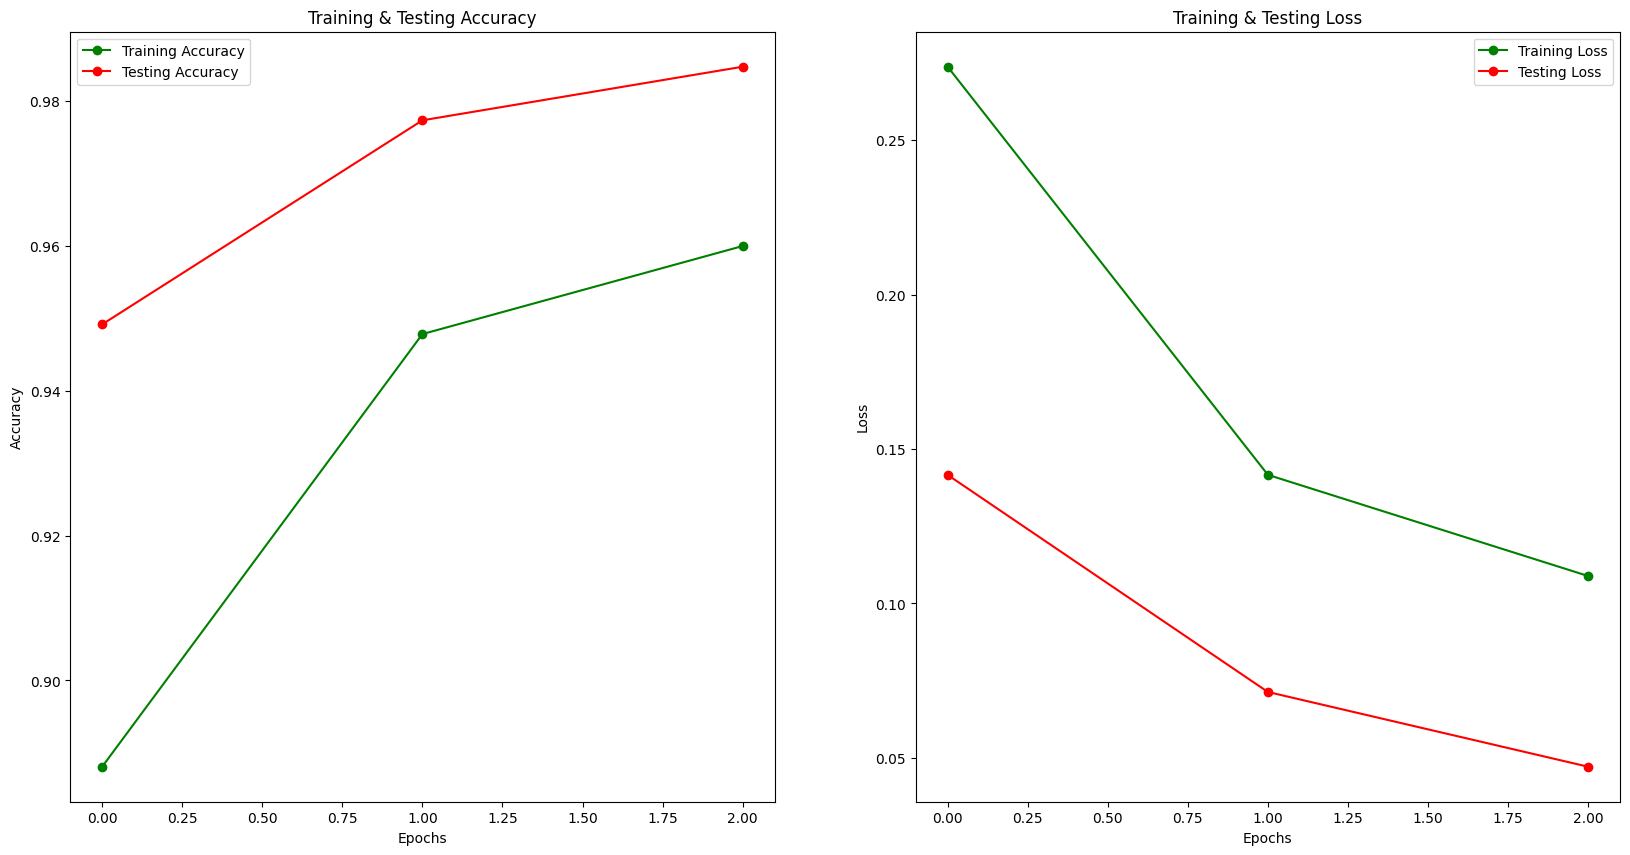

In [19]:
# Get the actual number of epochs from the history object
actual_epochs = len(history.history['accuracy'])

epochs = [i for i in range(actual_epochs)]  # Adjust epochs array based on the actual number of epochs
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

## Step 10: Confusion Matrix and Classification Report

351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      5858
    Not Fake       0.98      0.99      0.98      5367

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



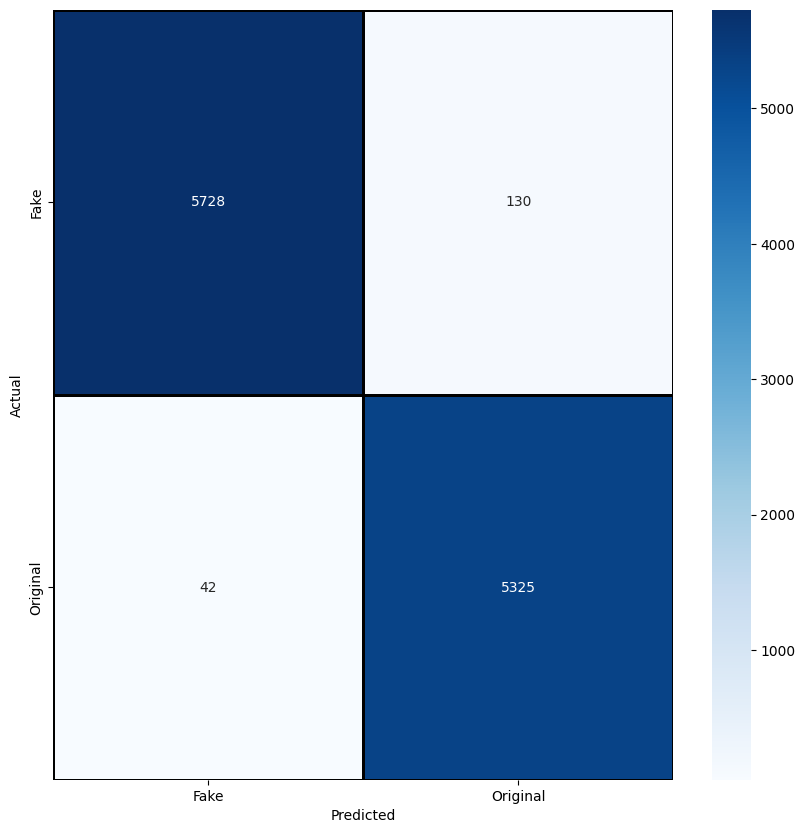

In [20]:
# Use predict method to get predicted probabilities
pred_probabilities = model.predict(x_test)

# Threshold predicted probabilities to get predicted classes
pred = (pred_probabilities > 0.5).astype('int32')

print(classification_report(y_test, pred, target_names=['Fake', 'Not Fake']))
cm = confusion_matrix(y_test, pred)
cm = pd.DataFrame(cm, index=['Fake', 'Original'], columns=['Fake', 'Original'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Fake', 'Original'], yticklabels=['Fake', 'Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


BiLSTM

In [27]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.callbacks import ReduceLROnPlateau

# Example parameters
max_features = 10000  # Number of unique words
embed_size = 128  # Size of embedding vectors
maxlen = 100  # Maximum length of input sequences
batch_size = 32  # Batch size for training
epochs = 3  # Number of training epochs

# Initialize the embedding matrix with random values for demonstration
# This should be replaced with your actual embedding weights
# Example shape: (max_features, embed_size)
embedding_matrix = np.random.rand(max_features, embed_size)  # Replace this with your actual embeddings

# Prepare your training and testing data (replace with actual data)
x_train = np.random.randint(0, max_features, (1000, maxlen))  # Example training data
y_train = np.random.randint(0, 2, 1000)  # Example binary labels
x_test = np.random.randint(0, max_features, (200, maxlen))  # Example test data
y_test = np.random.randint(0, 2, 200)  # Example binary labels


# Define learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# ---------------

# Define the BiLSTM model
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# First Bidirectional LSTM layer with 128 units
model_bilstm.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25)))

# Second Bidirectional LSTM layer with 64 units
model_bilstm.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1)))

# Dense layer with 32 units
model_bilstm.add(Dense(units=32, activation='relu'))

# Output layer with sigmoid activation (for binary classification)
model_bilstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bilstm = model_bilstm.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.5349 - loss: 0.7125 - val_accuracy: 0.4350 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.4533 - loss: 0.6983 - val_accuracy: 0.5650 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5039 - loss: 0.6942 - val_accuracy: 0.5650 - val_loss: 0.6883 - learning_rate: 0.0010


In [28]:
print("Accuracy on Training Data:", model_bilstm.evaluate(x_train, y_train)[1] * 100, "%")
print("Accuracy on Testing Data:", model_bilstm.evaluate(x_test, y_test)[1] * 100, "%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5214 - loss: 0.6905
Accuracy on Training Data: 50.700002908706665 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5599 - loss: 0.6885
Accuracy on Testing Data: 56.49999976158142 %


GRU

In [29]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_gru.add(GRU(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model_gru.add(GRU(units=64, recurrent_dropout=0.1, dropout=0.1))
model_gru.add(Dense(units=32, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_gru = model_gru.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.4544 - loss: 222.9244 - val_accuracy: 0.5650 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.4916 - loss: 5.2181 - val_accuracy: 0.5250 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.4990 - loss: 2.3464 - val_accuracy: 0.5000 - val_loss: 0.6910 - learning_rate: 0.0010


CNN

In [30]:
from keras.layers import Conv1D, GlobalMaxPooling1D
batch_size = 256
epochs = 3
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

model_cnn = Sequential()
model_cnn.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Convolutional layer
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())

# Dense layers
model_cnn.add(Dense(units=32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.5184 - loss: 0.8237 - val_accuracy: 0.5650 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4979 - loss: 0.7517 - val_accuracy: 0.4350 - val_loss: 0.7312 - learning_rate: 0.0010
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5130 - loss: 0.7069
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5110 - loss: 0.7073 - val_accuracy: 0.5650 - val_loss: 0.6853 - learning_rate: 0.0010


regularization L2

In [31]:
from keras.regularizers import l2

model_regularized = Sequential()
model_regularized.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_regularized.add(LSTM(units=128, recurrent_dropout=0.25, dropout=0.25, kernel_regularizer=l2(0.001)))
model_regularized.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)))
model_regularized.add(Dense(1, activation='sigmoid'))

model_regularized.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lr = model_regularized.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=epochs, callbacks=[learning_rate_reduction])



Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - accuracy: 0.4947 - loss: 0.9669 - val_accuracy: 0.4250 - val_loss: 0.9462 - learning_rate: 0.0010
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.4910 - loss: 0.9422 - val_accuracy: 0.4350 - val_loss: 0.9373 - learning_rate: 0.0010
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.5205 - loss: 0.9277 - val_accuracy: 0.5100 - val_loss: 0.9213 - learning_rate: 0.0010
